This contains the steps in solving the Titanic competition of Kaggle. 

This had been made after the completion of the DataQuest DS initial challenges/missions. So, it's advisable to go to DataQuest, since I might be missing additional explanation or discussion on the various steps made that may seem unclear to beginners.

The Titanic competition involves predicting the survival rate through machine learning.

The first step is to instantiate requirement and prepare the data for training.

Pandas is a very useful tool for processing datasets.
We can easily format the csv file into usable data.
As for sklearn(sci-kit learn), the machine learning and statistical functions it provides will be helpful later on in evaluating or validating the results.

In [4]:
import pandas as pd
import numpy as np
import csv as csv

training_df = pd.read_csv('data/train.csv', header=0)
training_df.describe()
print training_df

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
17            18         1       2   
18            19         0       3   
19            20         1       3   
20            21         0       2   
21            22         1       2   
22            23         1       3   
23            24         1       1   
24            25         0       3   
25          

It can be seen in the data, that more than few values are missing in some columns such as Age or Embarked.
Since we are try to determine if these predictors have a relationship to survivability, it is vital to clean up and prepare the training data to minimize 'noise' so as not to skew the accuracy of predictions. This is what we call 'overfitting' when inaccurate data is covered by machine learning, which generates inaccurate results that might lead to wrong conclusions.

We'll do this by using the median (not to be confused with mean) of the set, and provide a default value to missing data for the Embarked column.


In [5]:
training_df["Age"] = training_df["Age"].fillna(training_df["Age"].median())
training_df["Embarked"] = training_df["Embarked"].fillna("S")

This also requires transforming some data to ordinal symbols for our classifier later

In [6]:
training_df.loc[training_df["Sex"] == "male", "Sex"] = 0
training_df.loc[training_df["Sex"] == "female", "Sex"] = 1

In [7]:
training_df.loc[training_df["Embarked"] == "S", "Embarked"] = 0
training_df.loc[training_df["Embarked"] == "C", "Embarked"] = 1
training_df.loc[training_df["Embarked"] == "Q", "Embarked"] = 2

Now that we've prepared the data, we'll use linear regression first to see if there are direct relationships to survivability. We can also test our initial assumptions when looking at the data before we can draw a conclusion.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn import cross_validation

predictors =  ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
alg = LinearRegression()

kf = KFold(training_df.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_predictors = (training_df[predictors].iloc[train,:])
    train_target = training_df["Survived"].iloc[train]
    alg.fit(train_predictors, train_target)
    
    test_predictions = alg.predict(training_df[predictors].iloc[test,:])
    predictions.append(test_predictions)

#since predictions are in 3 (from n-folds) separate arrays (combine them)
predictions = np.concatenate(predictions, axis=0)

#map predictions to outcomes (>.5 survives(1), <= .5 (dies))
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

#then we check and compare the accuracy
accuracy = sum(predictions[predictions == training_df["Survived"]]) / len(predictions)

print accuracy

0.783389450056


/home/rogue/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


As can be seen, we only have 78 percent accuracy when using linear regression. This can easily be explained that in predictors such as Age, while there are indeed many who didn't survived accordingly, there are also cases wherein some survived. 

We can also use cross_validation to validate our predictors much more easily.

In [9]:
import pandas
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression

titanic_test = pandas.read_csv("data/train.csv")

titanic_test['Age'] = titanic_test['Age'].fillna(titanic_test['Age'].median())
titanic_test.loc[titanic_test['Sex'] == 'male', 'Sex'] = 0
titanic_test.loc[titanic_test['Sex'] == 'female', 'Sex'] = 1

titanic_test['Embarked'] = titanic_test['Embarked'].fillna('S')
titanic_test.loc[titanic_test['Embarked']=='S', 'Embarked'] = 0
titanic_test.loc[titanic_test['Embarked']=='C', 'Embarked'] = 1
titanic_test.loc[titanic_test['Embarked']=='Q', 'Embarked'] = 2

titanic_test['Fare'] = titanic_test['Fare'].fillna(titanic_test['Fare'].median())

alg = LogisticRegression(random_state=1)
scores = cross_validation.cross_val_score(alg, titanic_test[predictors], titanic_test["Survived"], cv=3)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.787878787879


However, we can improve this by using a Random Forest classifier, which is a better algorithm for the non-linear tendencies/relationships in our dataset. Simply put, the random forest algorithm involves creating decision trees that have slightly randomized input data and splitpoint, and evaluating the overall average prediction of the trees.

We can use the RandomForestClassifier implementation in sklearn.

In [10]:
import pandas
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
titanic = pandas.read_csv("data/train.csv")
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median())
titanic.loc[titanic['Sex'] == 'male', 'Sex'] = 0
titanic.loc[titanic['Sex'] == 'female', 'Sex'] = 1

titanic['Embarked'] = titanic['Embarked'].fillna('S')
titanic.loc[titanic['Embarked']=='S', 'Embarked'] = 0
titanic.loc[titanic['Embarked']=='C', 'Embarked'] = 1
titanic.loc[titanic['Embarked']=='Q', 'Embarked'] = 2

titanic['Fare'] = titanic['Fare'].fillna(titanic['Fare'].median())
# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic['Survived'], cv=3)
print(scores.mean())

0.801346801347


Using Random Forests, we've increased the accuracy of our predictions. However, we can tweak the parameters such as no. of trees (n_estimators), the no. of splits in our decision trees (min_samples_split) and sample leafs (min_samples_leaf) to minimize overfitting. 

In [11]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic['Survived'], cv=3)
print(scores.mean())

0.820426487093


By changing the sample size to 150, splits to 4 and leafs to 2, we've increased the accuracy score to around 2 percent.
However, we still have other columns in the data that we can test to increase the overall accuracy of our algorithm.

One of those is testing whether the name could be a factor (as unlikely as it sounds). This is done through feature engineering, namely, by creating a new feature, by identifying key information in the data which can help us increase the accuracy of our predictions.

In this case, our data includes the titles of the passengers. We can thus, generate a new feature by extracting their titles and including it in our predictors.

Let's add a few features that could help us.

In [12]:
# Add Features FamilySize, because more people can support each other to survive
# Create total count (SiblingSpouse + ParentChild)
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

# Add Name Length because the longer the name, the more important sounding the invidual might be
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

Our data also includes the titles of the passengers. We can thus, generate a new feature by extracting their titles and including it in our predictors.

In [13]:
import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pandas.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print(pandas.value_counts(titles))

# Add in the title column.
titanic["Title"] = titles
print titanic

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64
     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14      

Since we've extracted the title from the names, we can group the families together. Of course, the more members of the family there are, the more likely it is that they'll help each other to survive.

In [14]:
import operator

# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique id.
print(pandas.value_counts(family_ids))

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


However, more features doesn't mean more accurate prediction, in fact, we should only select features that correlate more with the survival data.

We can use sklearn's SelectKBest function, that helps us select the best features from the data, and allows us to select how many features to to use.

In [15]:
matplotlib inline

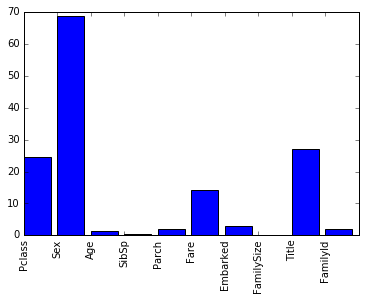

0.811447811448


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic['Survived'], cv=3)
print(scores.mean())

As can be seen, the feature that correlates to survivability is Sex, Passenger Class, Title and Fare.

Aside from feature selection, we can also use Gradient Boosting on our classifier, which involves training decision trees one after another to recognize the errors of the trees before it.

And of course, we can use different classifiers to generate predictions which we can combine to have a more realistic approximation. While similar classifiers like a random forests and a decision tree might not work well because of their similarity, combining it with a linear regression works well.

In the next example, we're using a gradient boosting classifier and linear regression to estimate prediction accuracy.

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.819304152637


/home/rogue/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:37: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


Now that we've familiarized ourselves on ways to improve our prediction, we may start on using our algorithm on our test data.

Like in the first step, let's prepare our test data.

In [21]:
# LOAD TRAINING AND TEST DATA  --------------------------------

training_df = pd.read_csv("data/train.csv")
testing_df = pd.read_csv("data/test.csv")

# CLEAN UP / FIX DATA  --------------------------------

training_df["Age"] = training_df["Age"].fillna(training_df["Age"].median())
training_df["Fare"] = training_df["Fare"].fillna(training_df["Fare"].median())
training_df["Embarked"] = training_df["Embarked"].fillna("S")

training_df.loc[training_df["Sex"] == "male", "Sex"] = 0
training_df.loc[training_df["Sex"] == "female", "Sex"] = 1
training_df.loc[training_df["Embarked"] == "S", "Embarked"] = 0
training_df.loc[training_df["Embarked"] == "C", "Embarked"] = 1
training_df.loc[training_df["Embarked"] == "Q", "Embarked"] = 2

testing_df["Age"] = testing_df["Age"].fillna(testing_df["Age"].median())
testing_df["Fare"] = testing_df["Fare"].fillna(testing_df["Fare"].median())
testing_df["Embarked"] = testing_df["Embarked"].fillna("S")

testing_df.loc[testing_df["Sex"] == "male", "Sex"] = 0
testing_df.loc[testing_df["Sex"] == "female", "Sex"] = 1
testing_df.loc[testing_df["Embarked"] == "S", "Embarked"] = 0
testing_df.loc[testing_df["Embarked"] == "C", "Embarked"] = 1
testing_df.loc[testing_df["Embarked"] == "Q", "Embarked"] = 2

# FEATURE FUNCTIONS / VARIABLES  --------------------------------

training_df["FamilySize"] = training_df["SibSp"] + training_df["Parch"]
training_df["NameLength"] = training_df["Name"].apply(lambda x: len(x))

testing_df["FamilySize"] = testing_df["SibSp"] + testing_df["Parch"]
testing_df["NameLength"] = testing_df["Name"].apply(lambda x: len(x))

title_mapping = {
    "Mr": 1,
    "Miss": 2,
    "Mrs": 3,
    "Master": 4,
    "Dr": 5,
    "Rev": 6,
    "Major": 7,
    "Col": 7,
    "Mlle": 8,
    "Mme": 8,
    "Don": 9,
    "Lady": 10,
    "Countess": 10,
    "Jonkheer": 10,
    "Sir": 9,
    "Capt": 7,
    "Ms": 2,
    "Dona": 10
}

# extract title from passengers name
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

family_id_mapping = {}

# extract last name and assign / add family id 
def get_family_id(row):
    # find last name 
    last_name = row["Name"].split(",")[0]
    # create family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the max id from the mapping and add one if
            # we don't have an id
            current_id = (max(family_id_mapping.items(), 
                key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]


# APPLY FEATURES   --------------------------------

training_titles = training_df["Name"].apply(get_title)
testing_titles = testing_df["Name"].apply(get_title)

for k, v in title_mapping.items():
    training_titles[training_titles == k] = v
    testing_titles[testing_titles == k] = v

training_df["Title"] = training_titles
testing_df["Title"] = testing_titles


# Get the family ids with the apply method
family_ids = training_df.apply(get_family_id, axis=1)
test_family_ids = testing_df.apply(get_family_id, axis=1)

# Categorize familysize < 3 into one
family_ids[training_df["FamilySize"] < 3] = -1
test_family_ids[testing_df["FamilySize"] < 3] = -1

training_df["FamilyId"] = family_ids
testing_df["FamilyId"] = test_family_ids
print training_df

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
17            18         1       2   
18            19         0       3   
19            20         1       3   
20            21         0       2   
21            22         1       2   
22            23         1       3   
23            24         1       1   
24            25         0       3   
25          

We can then apply our algorithm to the test data

In [30]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), predictors]
]

full_predictions = []
td_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(training_df[predictors], training_df["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(testing_df[predictors].astype(float))[:,1]
    training_data_prediction = alg.predict_proba(training_df[predictors].astype(float))[:,1]
    full_predictions.append(predictions)
    td_predictions.append(training_data_prediction)

# The gradient boosting classifier generates better predictions, so we weight it higher.
full_predictions = (full_predictions[full_predictions==0] * 3 + full_predictions[full_predictions==1]) / 4
full_predictions[full_predictions <= .5] = 0
full_predictions[full_predictions > .5] = 1

td_predictions = (td_predictions[td_predictions==0] * 3 + td_predictions[td_predictions==1]) / 4
td_predictions[td_predictions <= .5] = 0
td_predictions[td_predictions > .5] = 1

full_predictions = full_predictions.astype(int)

accuracy = sum(td_predictions[td_predictions == training_df["Survived"]]) / len(td_predictions)
print accuracy

0.851851851852


/home/rogue/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


And that's it!
We can add the code block to generate a submission file to Kaggle. Although we've got around 0.85% accuracy on the training data. The test data is likely to have a different result. This is perhaps due to some columns or relationships that are more apparent in the test data. 
Well, good luck and happy coding!

In [ ]:
submission = pd.DataFrame({
    "PassengerId": testing_df["PassengerId"],
    "Survived": predictions
   })

submission.to_csv("data/kaggle-titanic-2016-07-18.csv", index=False)
